In [9]:
import warnings
import json

from pandas.io.json import json_normalize

warnings.filterwarnings(action='ignore')
import pandas as pd  # 데이터 분석을 위한 전처리를 위해 import 한다.
import matplotlib as mpl  # matplolib에서 음수 데이터의 '-'부호가 깨지는 것을 방지하기위해 import 한다.

mpl.rcParams['axes.unicode_minus'] = False  # matplolib에서 음수 데이터의 '-'부호가 깨지는 것을 방지한다.
import matplotlib.pyplot as plt  # 시각화를 하기 위해 import 한다.
import seaborn as sns

import numpy as np
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

plt.rcParams["font.size"] = 10  # matplolib에서 사용할 글꼴 크기 설정
plt.rcParams["font.family"] = "NanumGothicCoding"  # matplolib에서 사용할 글꼴 설정

pd.options.display.float_format = '{:,.5f}'.format

In [10]:
rank = pd.read_csv('data/rank.csv')
rank_final = pd.read_csv('data/rank_final - changed.csv')

In [11]:
characterNamesEn = pd.read_csv('data/characterList - origin.csv')  # 실험체 영문명
characterNamesKr = pd.read_csv('data/characterList - changed.csv')  # 실험체 한글명
skinNames = pd.read_csv('data/skin - changed.csv')  # 스킨
weaponNames = pd.read_csv('data/weapon - changed.csv')  # 무기
armorNames = pd.read_csv('data/armor - changed.csv')  # 방어구
# 무기별 사용실험체 추가
weapon = pd.DataFrame({'num': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25],
                       'name': ["글러브", "톤파", "방망이", "채찍", "투척", "암기", "활", "석궁", "권총", "돌격소총", "저격총", "망치", "도끼", "단검",
                                "양손검", "쌍검", "창", "쌍절곤", "레이피어", "기타", "카메라", "아르카나", "VF의수"],
                       'character': [['현우', '레온', '얀', '니키', '리다이린'], ['현우', '레온', '얀', '아이작', '알렉스'],
                                     ['바바라', '매그너스', '루크', '띠아'], ['레녹스', '마이', '라우라'],
                                     ['시셀라', '이바', '이렘', '아드리아나', '윌리엄', '자히르', '셀린'],
                                     ['시셀라', '엠마', '자히르', '타지아', '클로에', '혜진', '알렉스'],
                                     ['리오', '나딘', '혜진'], ['나딘', '칼라'], ['아야', '로지', '제니', '아이솔', '실비아', '알렉스'],
                                     ['아야', '아이솔', '헤이즈'],
                                     ['아야', '버니스', '테오도르'], ['매그너스', '수아', '일레븐'], ['재키', '마커스', '에스텔'],
                                     ['재키', '쇼이치', '캐시', '다니엘', '쇼우'],
                                     ['재키', '유키', '피오라', '에이든', '알렉스'], ['재키', '카밀로', '유키', '캐시'], ['쇼우', '펠릭스', '피오라'],
                                     ['리다이린', '피올로'],
                                     ['피오라', '키아라', '카밀로', '아델라', '엘레나'], ['하트', '프리야'], ['나타폰', '마르티나'],
                                     ['요한', '비앙카', '엠마', '아디나'], ['에키온']]})

In [12]:
characterList = pd.DataFrame()

for i in range(len(rank_final.nameW.value_counts())):
    gg = f'{"{"}"nameW" : "{rank_final.nameW.value_counts().index[i]}","code" : {rank_final[rank_final.nameW == rank_final.nameW.value_counts().index[i]].characterNum.values[0]}{"}"}'

    characterList = pd.concat([characterList, json_normalize(json.loads(gg))], ignore_index=True)
characterList = characterList.sort_values('code')
characterList = characterList.reset_index(drop=True)
# characterList

In [13]:
# 62개 실험체의 핵심 정보

df_code = pd.DataFrame()
df_characterStats = pd.DataFrame()

for i in range(84):
    character = pd.concat([df_code, rank_final[rank_final.nameW == characterList.nameW[i]]])
    stat = (
        # 실험체 이름
        f'{"{"}"characterName" : "{characterList.nameW[i]}", '
        # 실험체 번호
        f'"characterCode" : {characterList.code[i]}, '
        # 가장 많이 사용한 스킨, 사용 횟수
        f'"mostSkin" : "{skinNames[skinNames.code == int(character.skinCode.value_counts().head(1).index[0])].values[0][0]}", "mostSkinCount" : {character.skinCode.value_counts().head(1).values[0]}, '

        # 무기(이대로 사용하면 가장 많이 사용한 무기로 나머지 무기도 통합됨)
        f'"characterWeapon" : "{weapon[weapon.num == character.bestWeapon.values[0]].name.values[0]}",'

        # 여기부터 마지막까지 아래와 같은 리스트형식으로 무기별 분류 필요
        #  ([ {무기군1: 킬수}, {무기군2 : 킬수} ...])
        #  ([ {무기군1: 루트무기}, {무기군2 : 루트무기} ...] )

        # 평균 플레이어 킬수
        f'"averageKillPlayer" : {character.playerKill.mean():.2f}, '
        # 평균 플레이어 데미지
        f'"averageDamegeToPlayer" : {character.damageToPlayer.mean():.2f}, '
        # 평균 야동 킬수
        f'"averageKillMonster" : {character.monsterKill.mean():.2f}, '
        # 평균 야동 데미지
        f'"averageDamegeToMonster" : {character.damageToMonster.mean():.2f}, '
        # 게임 플레이 수
        f'"totalGames" : {character.count()[0]}, '
        # # 평균 승률 => 자히르 투척 승률 0%짜리 터짐
        f'"winRate" : {character[character.victory == 1].victory.count() / character.victory.count():.2f}, '

        # 평균 등수
        f'"averageRank" : {character[character.escapeState != 3].gameRank.mean():.2f}, '
        # 탈출 횟수
        f'"escapeCount" : {character[character.escapeState == 3].escapeState.count()}, '
        # 평균 mmr 획득률
        f'"averageMMR" : {character.mmrGain.mean():.2f}, '
        # 픽률
        f'"pickRate" : {character.count()[0] / 19248 * 100:.2f},'


        # 최종 아이템, 사용 횟수
        f'"finalWeapon" : "{weaponNames[weaponNames.code == int(character["equipment.0"].value_counts().head(1).index[0])].values[0][1]}", "finalWeaponCount" : {character["equipment.0"].value_counts().head(1).values[0]}, '
        f'"finalBody" : "{armorNames[armorNames.code == int(character["equipment.1"].value_counts().head(1).index[0])].values[0][1]}", "finalBodyCount" : {character["equipment.1"].value_counts().head(1).values[0]}, '
        f'"finalHead" : "{armorNames[armorNames.code == int(character["equipment.2"].value_counts().head(1).index[0])].values[0][1]}", "finalHeadCount" : {character["equipment.2"].value_counts().head(1).values[0]}, '
        f'"finalArm" : "{armorNames[armorNames.code == int(character["equipment.3"].value_counts().head(1).index[0])].values[0][1]}", "finalArmCount" : {character["equipment.3"].value_counts().head(1).values[0]}, '
        f'"finalFoot" : "{armorNames[armorNames.code == int(character["equipment.4"].value_counts().head(1).index[0])].values[0][1]}", "finalFootCount" : {character["equipment.4"].value_counts().head(1).values[0]}, '
        f'"finalTinkled" : "{armorNames[armorNames.code == int(character["equipment.5"].value_counts().head(1).index[0])].values[0][1]}", "finalTinkledCount" : {character["equipment.5"].value_counts().head(1).values[0]}, '

        # 가장 많이 선택한 루트 아이템, 사용 횟수
        f'"routeWeapon" : "{weaponNames[weaponNames.code == int(character["equipFirstItemForLog.0"].value_counts().head(1).index[0][1:-1])].values[0][1]}", "routeWeaponCount" : {character["equipFirstItemForLog.0"].value_counts().head(1)[0]}, '
        f'"routeBody" : "{armorNames[armorNames.code == int(character["equipFirstItemForLog.1"].value_counts().head(1).index[0][1:-1])].values[0][1]}", "routeBodyCount" : {character["equipFirstItemForLog.1"].value_counts().head(1)[0]}, '
        f'"routeHead" : "{armorNames[armorNames.code == int(character["equipFirstItemForLog.2"].value_counts().head(1).index[0][1:-1])].values[0][1]}", "routeHeadCount" : {character["equipFirstItemForLog.2"].value_counts().head(1)[0]}, '
        f'"routeArm" : "{armorNames[armorNames.code == int(character["equipFirstItemForLog.3"].value_counts().head(1).index[0][1:-1])].values[0][1]}", "routeArmCount" : {character["equipFirstItemForLog.3"].value_counts().head(1)[0]}, '
        f'"routeFoot" : "{armorNames[armorNames.code == int(character["equipFirstItemForLog.4"].value_counts().head(1).index[0][1:-1])].values[0][1]}", "routeFootCount" : {character["equipFirstItemForLog.4"].value_counts().head(1)[0]}, '

        f'"routeTinkled" : "", "routeTinkledCount" : ""{"}"}'
    )
    df_characterStats = pd.concat([df_characterStats, json_normalize(json.loads(stat))], ignore_index=True)
    del character, stat
# df_characterStats


In [14]:
df_characterStats.characterName[45] = '알렉스'
# print(df_characterStats.characterName[45])
characterList.nameW[45] = '알렉스'
# print(characterList.nameW[45])

In [15]:
# 추가 필요!!!!!!!!
df_characterStats.loc[df_characterStats.characterName == '알렉스', 'characterWeapon'] = '톤파, 암기, 양손검, 권총'
# df_characterStats[df_characterStats.characterName=='알렉스'].characterWeapon

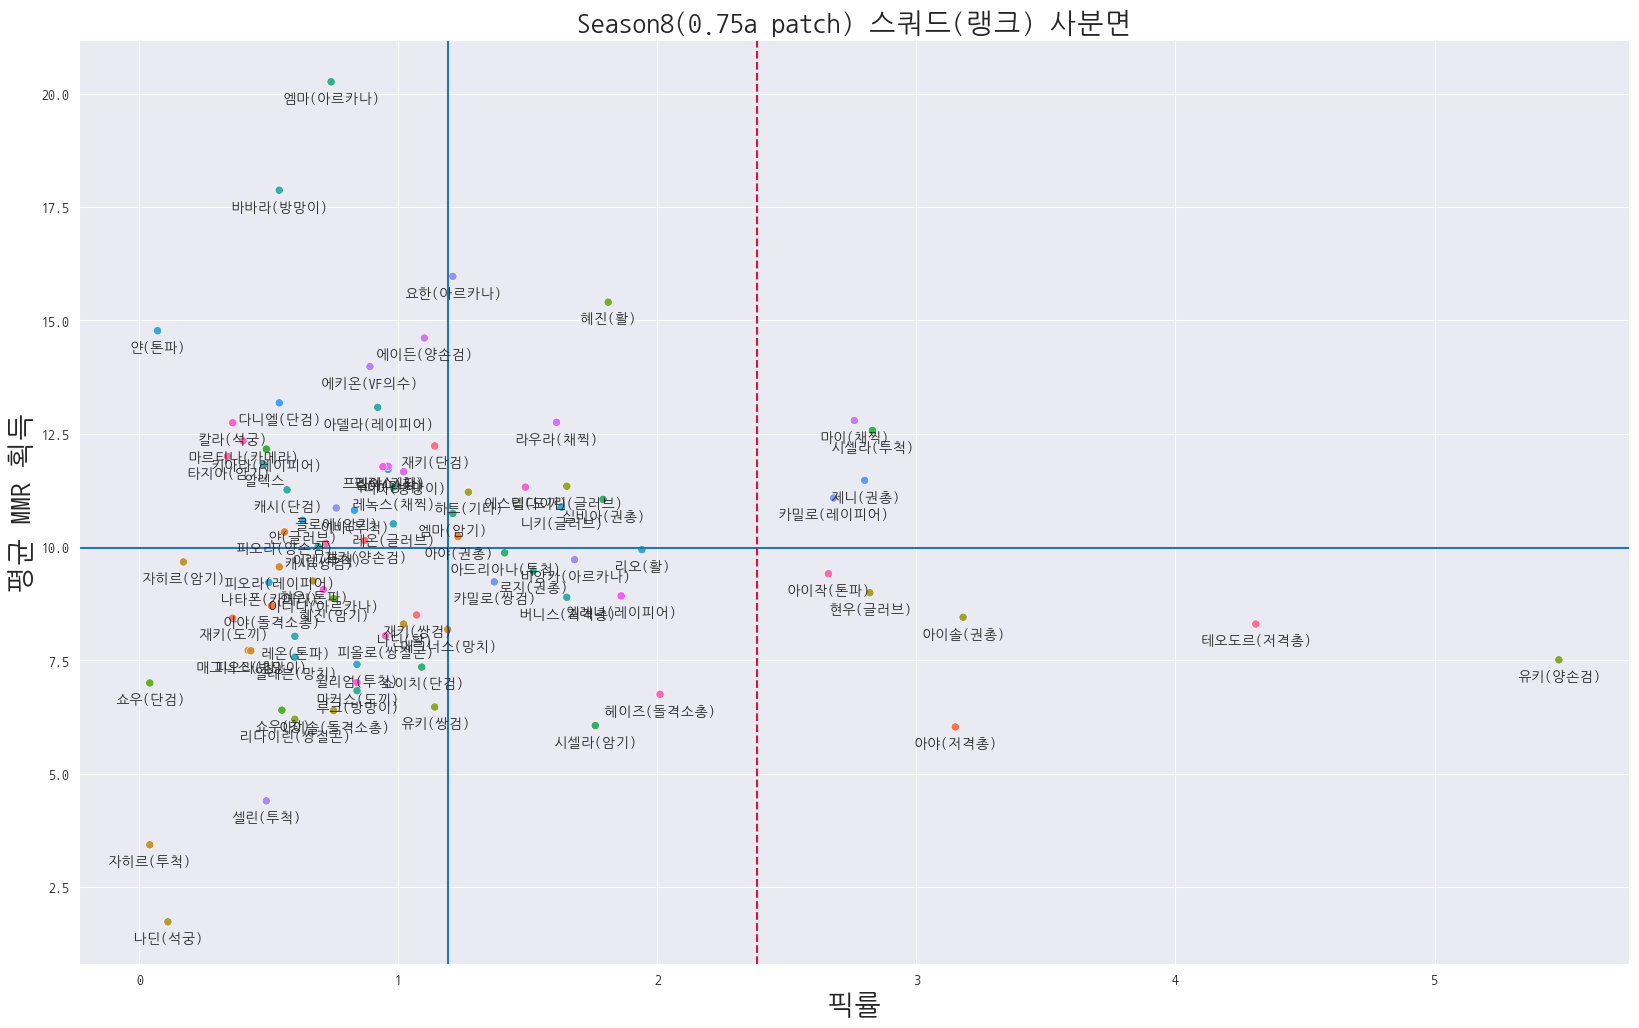

In [16]:
# 1-1
mmr = df_characterStats.averageMMR.mean()
pick = df_characterStats.pickRate.mean()
xy = pd.DataFrame()
for i, char in df_characterStats.iterrows():
    xy = pd.concat([xy, json_normalize(json.loads(
        f'{"{"}"characterCode" : {characterList[characterList.nameW == char.characterName].code.values[0]} ,"characterName" : "{characterList[characterList.nameW == char.characterName].nameW.values[0]}" ,"pickRate" : {df_characterStats.totalGames[i] / 19247 * 100:.2f}, "mmrGain" : {df_characterStats.averageMMR[i]:.2f}{"}"}'))],
                   ignore_index=True)

plt.figure(figsize=(20, 12))

plt.xlabel('픽률', fontsize=20)
plt.ylabel('평균 MMR 획득', fontsize=20)
# plt.scatter(xy.pickRate, xy.mmrGain)

sns.scatterplot(xy, x=xy.pickRate, y=xy.mmrGain, hue=xy.characterName, legend=False)
plt.title('Season8(0.75a patch) 스쿼드(랭크) 사분면', fontsize=20)
plt.axhline(mmr, 0, 1)
plt.axvline(pick, 0, 1)
plt.axvline(pick * 2, 0, 1, linestyle='--', color='crimson')
for _, j in xy.iterrows():
    plt.annotate(j.characterName,
                 (j.pickRate, j.mmrGain),
                 textcoords="offset points",  # 텍스트 위치를 (x,y)로 부터의 오프셋 (offset_x, offset_y)로 지정
                 xytext=(0, -15),  # (x, y)로 부터의 오프셋 (offset_x, offset_y)
                 ha='center')
plt.show()

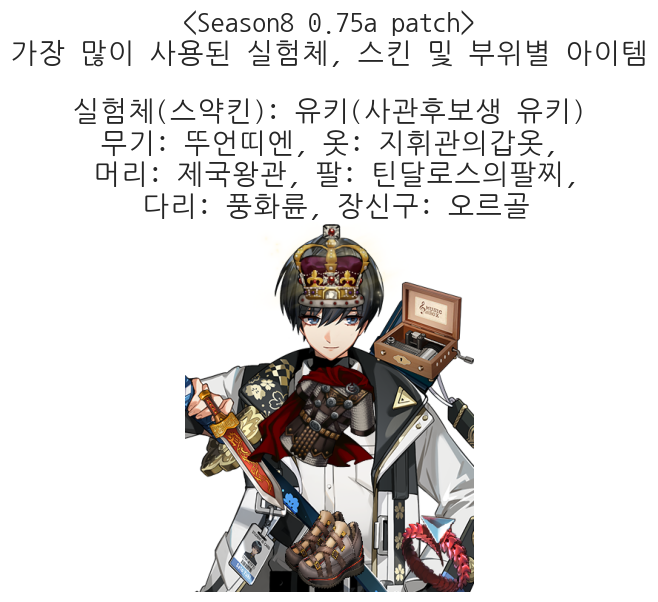

In [17]:
# fin
img = mpl.image.imread('data/mostItem/metaGolem-half.png')
plt.axis('off')
plt.title(f'<Season8 0.75a patch>\n'
          f'가장 많이 사용된 실험체, 스킨 및 부위별 아이템\n'
          f'\n실험체(스약킨): {characterNamesKr[characterNamesKr.code == rank_final.characterNum.value_counts().head(1).index[0]].name.values[0]}({skinNames[skinNames.code == rank_final[rank_final.characterNum == rank_final.characterNum.value_counts().head(1).index[0]].skinCode.values[0]].values[0][0]})\n'
          f'무기: {weaponNames[weaponNames.code == int(rank_final["equipFirstItemForLog.0"].value_counts().head(1).index[0][1:-1])].name.values[0]}, 옷: {armorNames[armorNames.code == int(rank_final["equipFirstItemForLog.1"].value_counts().head(1).index[0][1:-1])].name.values[0]},\n 머리: {armorNames[armorNames.code == int(rank_final["equipFirstItemForLog.2"].value_counts().head(1).index[0][1:-1])].name.values[0]}, 팔: {armorNames[armorNames.code == int(rank_final["equipFirstItemForLog.3"].value_counts().head(1).index[0][1:-1])].name.values[0]},\n 다리: {armorNames[armorNames.code == int(rank_final["equipFirstItemForLog.4"].value_counts().head(1).index[0][1:-1])].name.values[0]}, '

          # 루트 장신구 api가 null이 뜨는 버그가 있어서 최종장신구로 대체
          f'장신구: {armorNames[armorNames.code == int(rank_final["equipment.5"].value_counts().head(1).index[0])].name.values[0]}',
          fontsize=20)
plt.imshow(img)
plt.show()

In [18]:
df_characterStats

,characterName,characterCode,mostSkin,mostSkinCount,characterWeapon,averageKillPlayer,averageDamegeToPlayer,averageKillMonster,averageDamegeToMonster,totalGames,...,routeBody,routeBodyCount,routeHead,routeHeadCount,routeArm,routeArmCount,routeFoot,routeFootCount,routeTinkled,routeTinkledCount
0,재키(단검),1,스칼렛 코사지 재키,87,단검,2.88000,"8,349.14000",30.48000,"40,503.32000",219,...,성기사의갑옷,89,수정티아라,100,바이탈센서,168,경량화부츠,169,,
1,재키(쌍검),1,시스템쇼크 재키,78,쌍검,3.56000,"9,508.02000",28.12000,"34,974.54000",206,...,광학미채수트,63,수정티아라,119,바이탈센서,149,부케팔로스,126,,
2,재키(양손검),1,재키,84,양손검,2.55000,"7,205.29000",29.46000,"38,669.75000",167,...,광학미채수트,102,수정티아라,116,바이탈센서,98,부케팔로스,99,,
3,재키(도끼),1,시스템쇼크 재키,35,도끼,2.41000,"7,121.12000",30.71000,"37,961.72000",69,...,턱시도,40,성기사의투구,37,플라즈마아크,43,매버릭러너,37,,
4,아야(저격총),2,불꽃놀이 아야,413,저격총,2.66000,"11,468.78000",20.37000,"25,525.72000",607,...,지휘관의갑옷,454,황실부르고넷,402,틴달로스의팔찌,495,타키온브레이스,452,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,헤이즈(돌격소총),58,암흑가 헤이즈,224,돌격소총,2.46000,"11,080.11000",18.20000,"21,879.78000",386,...,지휘관의갑옷,266,황실부르고넷,295,틴달로스의팔찌,256,아이젠,242,,
80,아이작(톤파),59,암흑가 아이작,309,톤파,2.43000,"7,372.01000",18.62000,"21,601.14000",512,...,EOD수트,354,전술OPS헬멧,397,샤자한의검집,378,경량화부츠,281,,
81,타지아(암기),60,타지아,39,암기,3.33000,"9,196.26000",13.47000,"16,505.85000",66,...,고위사제복,57,제국왕관,60,아이기스,44,SCV,41,,
82,이렘(투척),61,눈싸움 이렘,107,투척,2.15000,"7,031.30000",15.59000,"18,930.38000",138,...,EOD수트,96,제국왕관,124,스포츠시계,80,타키온브레이스,56,,


재키(단검) 픽률: 1.14%, 승률: 0.27%, 평균 MMR획득: 12.23, 모스트 스킨: 스칼렛 코사지 재키
재키(쌍검) 픽률: 1.07%, 승률: 0.24%, 평균 MMR획득: 8.5, 모스트 스킨: 시스템쇼크 재키
재키(양손검) 픽률: 0.87%, 승률: 0.28%, 평균 MMR획득: 10.14, 모스트 스킨: 재키
재키(도끼) 픽률: 0.36%, 승률: 0.23%, 평균 MMR획득: 8.43, 모스트 스킨: 시스템쇼크 재키
평균 MMR획득: 9.97, 평균 픽률: 1.19%


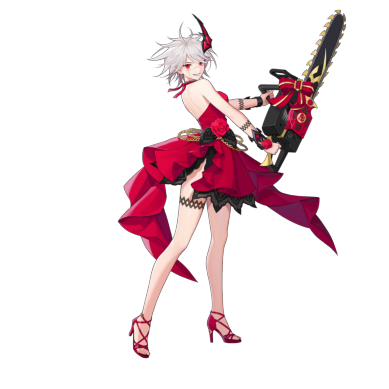

In [19]:
# 2-1
n = input('검색할 실험체')
if n not in characterNamesKr.name.values:
    print(f'{n}은(는) 존재하지 않는 실험체입니다.')
else:
    for _, c in df_characterStats.iterrows():
        if c.characterCode == characterNamesKr[characterNamesKr.name == n].values[0][0]:
            print(
                f'{c.characterName} 픽률: {c.pickRate}%, 승률: {c.winRate}%, 평균 MMR획득: {c.averageMMR}, 모스트 스킨: {c.mostSkin}')
    print(f'평균 MMR획득: {mmr:.2f}, 평균 픽률: {pick:.2f}%')
    img = mpl.image.imread(
        f'data/mostSkin/{df_characterStats[df_characterStats.characterCode == characterNamesKr[characterNamesKr.name == n].code.values[0]].index[0]}/full.png')
    plt.axis('off')
    plt.imshow(img)
    plt.show()

평균 MMR획득: 9.97, 평균 픽률: 1.19%
재키(쌍검)    픽률: 1.07%, 승률: 0.24%, 평균 MMR획득: 8.5, 모스트 스킨: 시스템쇼크 재키


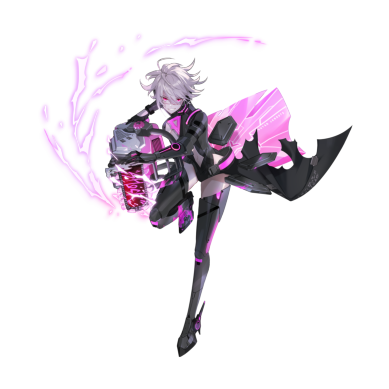

In [20]:
# 2-2
w = input('무기')
skinList = pd.DataFrame()
if n in characterNamesKr.name.values:
    skinList = pd.concat([skinList, df_characterStats[
        df_characterStats.characterCode == characterNamesKr[characterNamesKr.name == n].code.values[0]]],
                         ignore_index=True)
    gg = f'{n}({w})'
    if n == '알렉스':
        gg = '알렉스'
        if w in weapon.name.values:
            if w in f'[{skinList.characterWeapon.values}]':
                skin = df_characterStats[df_characterStats.characterName == f'{n}'].index[0]
                img = mpl.image.imread(
                    f'data/mostSkin/{skin}/full.png')
                plt.axis('off')
                plt.imshow(img)
                print(f'평균 MMR획득: {mmr:.2f}, 평균 픽률: {pick:.2f}%')
                if df_characterStats[df_characterStats.characterName == gg].mostSkin.values[0] == n:
                    print(
                        f'{df_characterStats[df_characterStats.characterName == gg].characterName.values[0]}    픽률: {df_characterStats[df_characterStats.characterName == gg].pickRate.values[0]}%, 승률: {df_characterStats[df_characterStats.characterName == gg].winRate.values[0]}%, 평균 MMR획득: {df_characterStats[df_characterStats.characterName == gg].averageMMR.values[0]}, 모스트 스킨: {n}(기본스킨)')
                else:
                    print(
                        f'{df_characterStats[df_characterStats.characterName == gg].characterName.values[0]}    픽률: {df_characterStats[df_characterStats.characterName == gg].pickRate.values[0]}%, 승률: {df_characterStats[df_characterStats.characterName == gg].winRate.values[0]}%, 평균 MMR획득: {df_characterStats[df_characterStats.characterName == gg].averageMMR.values[0]}, 모스트 스킨: {df_characterStats[df_characterStats.characterName == gg].mostSkin.values[0]}')
            else:
                print(f'{w}은(는) {n}가 사용하지 않는 무기입니다.')
                print(f'알렉스가 사용 가능한 무기는 {skinList.characterWeapon.values[0]} 입니다.')
        else:
            print(f'{w}은(는) 존재하지 않는 무기입니다.')
            print(f'알렉스가 사용 가능한 무기는 {skinList.characterWeapon.values[0]} 입니다.')
    elif w in skinList.characterWeapon.values:
        skin = df_characterStats[df_characterStats.characterName == f'{n}({w})'].index[0]
        img = mpl.image.imread(f'data/mostSkin/{skin}/full.png')
        plt.axis('off')
        plt.imshow(img)
        print(f'평균 MMR획득: {mmr:.2f}, 평균 픽률: {pick:.2f}%')
        if df_characterStats[df_characterStats.characterName == gg].mostSkin.values[0] == n:
            print(
                f'{df_characterStats[df_characterStats.characterName == gg].characterName.values[0]}    픽률: {df_characterStats[df_characterStats.characterName == gg].pickRate.values[0]}%, 승률: {df_characterStats[df_characterStats.characterName == gg].winRate.values[0]}%, 평균 MMR획득: {df_characterStats[df_characterStats.characterName == gg].averageMMR.values[0]}, 모스트 스킨: {n}(기본스킨)')
        else:
            print(
                f'{df_characterStats[df_characterStats.characterName == gg].characterName.values[0]}    픽률: {df_characterStats[df_characterStats.characterName == gg].pickRate.values[0]}%, 승률: {df_characterStats[df_characterStats.characterName == gg].winRate.values[0]}%, 평균 MMR획득: {df_characterStats[df_characterStats.characterName == gg].averageMMR.values[0]}, 모스트 스킨: {df_characterStats[df_characterStats.characterName == gg].mostSkin.values[0]}')
    else:
        print(f'{w}은(는) {n}가(이) 사용하지 않는 무기입니다.')
        print(f'{n}가(이) 사용 가능한 무기는 ', end='')
        for i in skinList.characterWeapon.values:
            print(i, end=' ')
        print(f'입니다.')
else:
    print(f'{n}은(는) 존재하지 않는 실험체입니다.')

In [21]:
# 3-0
df2 = pd.DataFrame()
df_weaponStats = pd.DataFrame()

for i in range(23):
    test = pd.concat([df2, rank_final[rank_final.bestWeapon == weapon.num[i]]])
    stat = (
        f'{"{"}"weaponName" : "{weapon.name[i]}", '
        f'"weaponCode" : {weapon.num[i]}, '
        # 평균 플레이어 킬수
        f'"averageKillPlayer" : {test.playerKill.mean():.2f}, '
        # 평균 플레이어 데미지
        f'"averageDamegeToPlayer" : {test.damageToPlayer.mean():.2f}, '
        # 평균 야동 킬수
        f'"averageKillMonster" : {test.monsterKill.mean():.2f}, '
        # 평균 야동 데미지
        f'"averageDamegeToMonster" : {test.damageToMonster.mean():.2f}, '
        # 게임 플레이 수
        f'"totalGames" : {test.count()[0]}, '
        # # 평균 승률 => 자히르 투척 승률 0%짜리 터짐
        f'"winRate" : {test[test.victory == 1].victory.count() / test.victory.count():.2f}, '

        # 평균 등수
        f'"averageRank" : {test[test.escapeState != 3].gameRank.mean():.2f}, '
        # 탈출 횟수
        f'"escapeCount" : {test[test.escapeState == 3].escapeState.count()}, '
        # 평균 mmr 획득률
        f'"averageMMR" : {test.mmrGain.mean():.2f}, '
        # 픽률
        f'"pickRate" : {test.count()[0] / 19248 * 100:.2f},'


        # 최종 아이템, 사용 횟수
        f'"finalWeapon" : "{weaponNames[weaponNames.code == int(test["equipment.0"].value_counts().head(1).index[0])].values[0][1]}", "finalWeaponCount" : {test["equipment.0"].value_counts().head(1).values[0]}, '
        f'"finalBody" : "{armorNames[armorNames.code == int(test["equipment.1"].value_counts().head(1).index[0])].values[0][1]}", "finalBodyCount" : {test["equipment.1"].value_counts().head(1).values[0]}, '
        f'"finalHead" : "{armorNames[armorNames.code == int(test["equipment.2"].value_counts().head(1).index[0])].values[0][1]}", "finalHeadCount" : {test["equipment.2"].value_counts().head(1).values[0]}, '
        f'"finalArm" : "{armorNames[armorNames.code == int(test["equipment.3"].value_counts().head(1).index[0])].values[0][1]}", "finalArmCount" : {test["equipment.3"].value_counts().head(1).values[0]}, '
        f'"finalFoot" : "{armorNames[armorNames.code == int(test["equipment.4"].value_counts().head(1).index[0])].values[0][1]}", "finalFootCount" : {test["equipment.4"].value_counts().head(1).values[0]}, '
        f'"finalTinkled" : "{armorNames[armorNames.code == int(test["equipment.5"].value_counts().head(1).index[0])].values[0][1]}", "finalTinkledCount" : {test["equipment.5"].value_counts().head(1).values[0]}, '

        # 가장 많이 선택한 루트 아이템, 사용 횟수
        f'"routeWeapon" : "{weaponNames[weaponNames.code == int(test["equipFirstItemForLog.0"].value_counts().head(1).index[0][1:-1])].values[0][1]}", "routeWeaponCount" : {test["equipFirstItemForLog.0"].value_counts().head(1)[0]}, '
        f'"routeBody" : "{armorNames[armorNames.code == int(test["equipFirstItemForLog.1"].value_counts().head(1).index[0][1:-1])].values[0][1]}", "routeBodyCount" : {test["equipFirstItemForLog.1"].value_counts().head(1)[0]}, '
        f'"routeHead" : "{armorNames[armorNames.code == int(test["equipFirstItemForLog.2"].value_counts().head(1).index[0][1:-1])].values[0][1]}", "routeHeadCount" : {test["equipFirstItemForLog.2"].value_counts().head(1)[0]}, '
        f'"routeArm" : "{armorNames[armorNames.code == int(test["equipFirstItemForLog.3"].value_counts().head(1).index[0][1:-1])].values[0][1]}", "routeArmCount" : {test["equipFirstItemForLog.3"].value_counts().head(1)[0]}, '
        f'"routeFoot" : "{armorNames[armorNames.code == int(test["equipFirstItemForLog.4"].value_counts().head(1).index[0][1:-1])].values[0][1]}", "routeFootCount" : {test["equipFirstItemForLog.4"].value_counts().head(1)[0]}, '

        f'"routeTinkled" : "", "routeTinkledCount" : ""{"}"}'
    )
    df_weaponStats = pd.concat([df_weaponStats, json_normalize(json.loads(stat))], ignore_index=True)
    del test, stat

#df_weaponStats

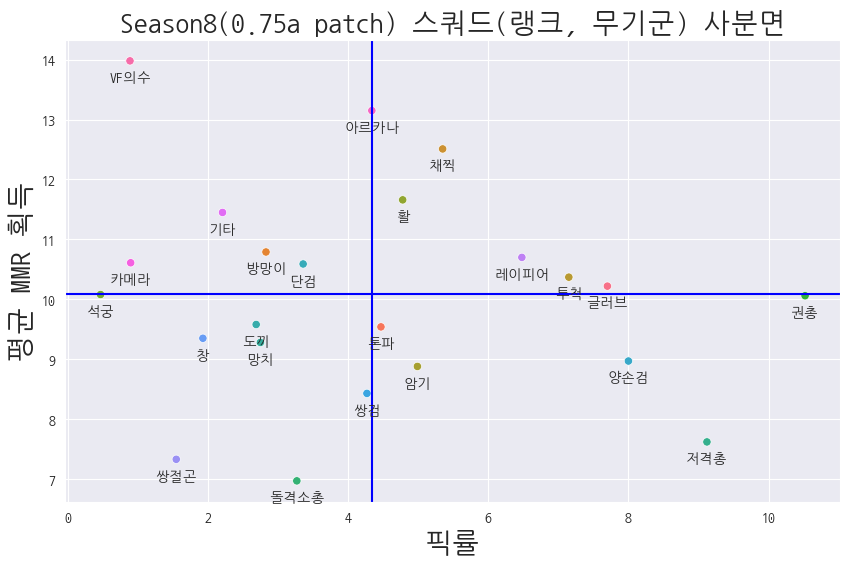

In [22]:
# 3-1
plt.figure(figsize=[10, 6])
wmmr = df_weaponStats.averageMMR.mean()
wpick = df_weaponStats.pickRate.mean()
gg = pd.DataFrame()

for i, char in df_weaponStats.iterrows():
    gg = pd.concat([gg, json_normalize(json.loads(
        f'{"{"}"weaponCode" : {weapon[weapon.name == char.weaponName].num.values[0]} ,"weaponName" : "{weapon[weapon.name == char.weaponName].name.values[0]}" ,"pickRate" : {df_weaponStats[df_weaponStats.weaponName == weapon[weapon.name == char.weaponName].name.values[0]].totalGames[i] / 19247 * 100:.2f}, "mmrGain" : {df_weaponStats[df_weaponStats.weaponName == weapon[weapon.name == char.weaponName].name.values[0]].averageMMR[i]:.2f}{"}"}'))])

plt.xlabel('픽률', fontsize=20)
plt.ylabel('평균 MMR 획득', fontsize=20)
# plt.scatter(xy.pickRate, xy.mmrGain)
sns.scatterplot(gg, x=gg.pickRate, y=gg.mmrGain, hue=gg.weaponName, legend=False)
plt.title('Season8(0.75a patch) 스쿼드(랭크, 무기군) 사분면', fontsize=20)
plt.axhline(wmmr, 0, 1, color='blue')
plt.axvline(wpick, 0, 1, color='blue')
for _, j in gg.iterrows():
    plt.annotate(j.weaponName,
                 (j.pickRate, j.mmrGain),
                 textcoords="offset points",  # 텍스트 위치를 (x,y)로 부터의 오프셋 (offset_x, offset_y)로 지정
                 xytext=(0, -15),  # (x, y)로 부터의 오프셋 (offset_x, offset_y)
                 ha='center')

plt.show()

권총, 저격총 채찍, 활 너프 예상
쌍절곤, 돌격소총 버프 예상


In [23]:
# 2-?
i = input('검색할 실험체')
if i in characterNamesKr.name.values:
    print(f'{i}가 사용 가능한 무기')
for _, j in weapon.iterrows():
    if i in j.character:
        print(j['name'], end=' ')
    elif i == '알렉스':
        print('알렉스는 권총, 톤파, 암기, 양손검을 동시에 사용하는 실험체입니다.')
        break
    elif i not in characterNamesKr.name.values:
        print(f'{i}은(는) 존재하지 않는 실험체입니다.')
        break

캐시가 사용 가능한 무기
단검 쌍검 

In [24]:
# 1-2-1
# xy = pd.DataFrame()
# for i, char in df_characterStats.iterrows():
#     xy = pd.concat([xy, json_normalize(json.loads(
#         f'{"{"}"characterCode" : {characterList[characterList.nameW == char.characterName].code.values[0]} ,"characterName" : "{characterList[characterList.nameW == char.characterName].nameW.values[0]}" ,"pickRate" : {df_characterStats.totalGames[i] / 19247 * 100:.2f}, "mmrGain" : {df_characterStats.averageMMR[i]:.2f}{"}"}'))],ignore_index=True)

face = []
for i in range(len(df_characterStats)):
    face.append(f'data/mostSkin/{i}/mini.png')

graphData = pd.DataFrame({'characterName': xy.characterName,
                          'x': xy.pickRate,
                          'y': xy.mmrGain,
                          'image': face,
                          })
graphData

,characterName,x,y,image
0,재키(단검),1.14000,12.23000,data/mostSkin/0/mini.png
1,재키(쌍검),1.07000,8.50000,data/mostSkin/1/mini.png
2,재키(양손검),0.87000,10.14000,data/mostSkin/2/mini.png
3,재키(도끼),0.36000,8.43000,data/mostSkin/3/mini.png
4,아야(저격총),3.15000,6.03000,data/mostSkin/4/mini.png
...,...,...,...,...
79,헤이즈(돌격소총),2.01000,6.75000,data/mostSkin/79/mini.png
80,아이작(톤파),2.66000,9.41000,data/mostSkin/80/mini.png
81,타지아(암기),0.34000,12.00000,data/mostSkin/81/mini.png
82,이렘(투척),0.72000,10.08000,data/mostSkin/82/mini.png


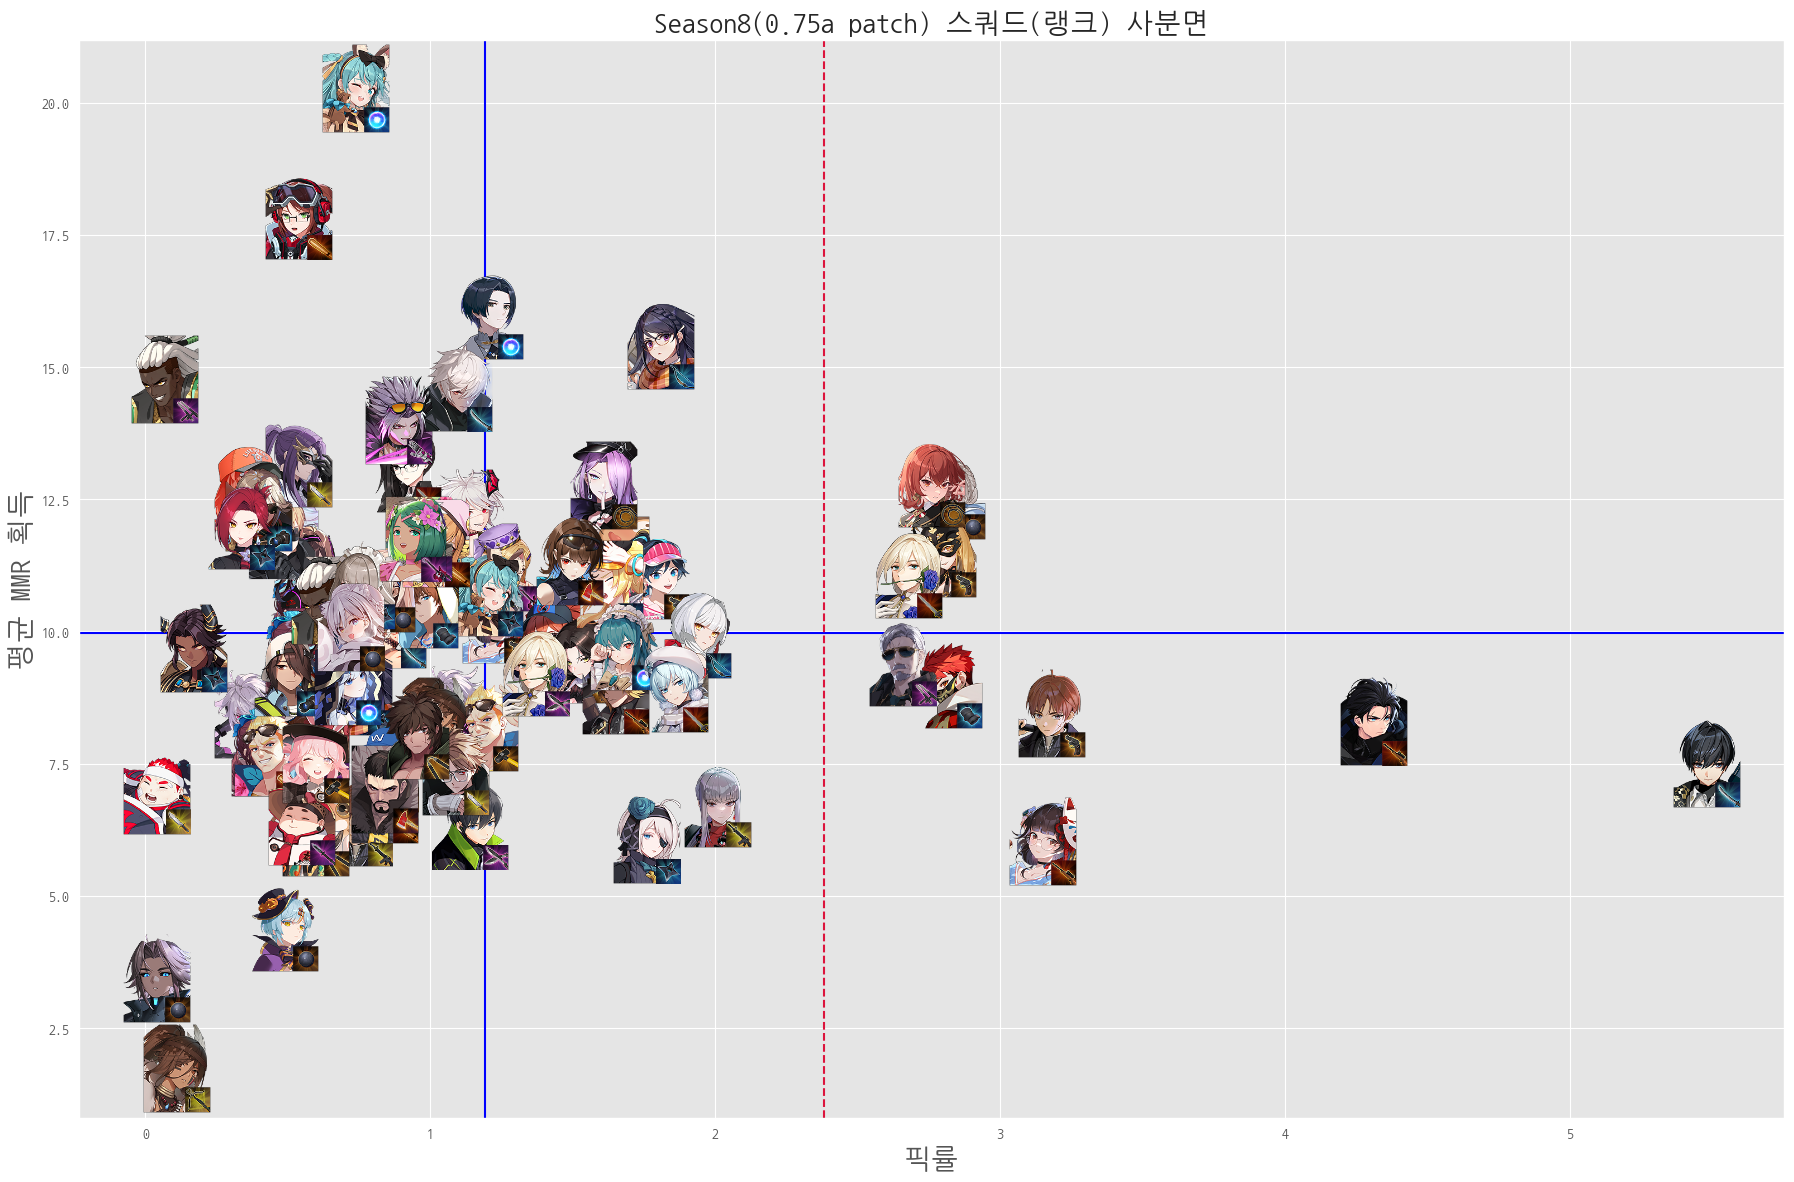

In [25]:
# 1-2-2
plt.style.use(style='ggplot')
plt.rcParams['figure.figsize'] = (22, 14)

fig, ax = plt.subplots()
plt.axhline(mmr, 0, 1, color='blue')
plt.axvline(pick, 0, 1, color='blue')
plt.axvline(pick * 2, 0, 1, linestyle='--', color='crimson')
for x, y, image_path, characterName in zip(graphData.x, graphData.y, graphData.image, graphData.characterName):
    if ax is None:
        ax = plt.gca()
    try:
        image = plt.imread(image_path)
    except TypeError:
        pass
    im = OffsetImage(image, zoom=0.4)
    x, y = np.atleast_1d(x, y)
    artists = []
    for x0, y0 in zip(x, y):
        ab = AnnotationBbox(im, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    # ax.annotate(characterName, (x, y), textcoords="offset points", xytext=(0, -25), ha='center') # 텍스트 출력

plt.title('Season8(0.75a patch) 스쿼드(랭크) 사분면', fontsize=20)
plt.xlabel('픽률', fontsize=20)
plt.ylabel('평균 MMR 획득', fontsize=20)

# plt.savefig('gg.png')
plt.show()

In [26]:
# print(f'pick: {pick:.2f}, mmr: {mmr:.2f}')
# for _,j in df_characterStats.iterrows():
#     if j.averageMMR>=mmr and j.pickRate>=pick:
#         print(f'{j.characterName}, pick: {j.pickRate}, mmr: {j.averageMMR}')

In [27]:
# 3-2-0
w = input('검색할 무기군')

xyw = pd.DataFrame()
for i, char in df_characterStats.iterrows():
    if char.characterWeapon == w:
        xyw = pd.concat([xyw, json_normalize(json.loads(f'{"{"}"characterCode" : {char.characterCode} '
                                                        f',"characterName" : "{char.characterName}" '
                                                        f',"pickRate" : {df_characterStats[df_characterStats.characterWeapon == w].totalGames[i] / 19247 * 100:.2f}, '
                                                        f'"mmrGain" : {df_characterStats[df_characterStats.characterWeapon == w].averageMMR[i]:.2f}{"}"}'))],
                        ignore_index=True)

if w in ['권총', '양손검', '암기', '톤파']:
    xyw = pd.concat([xyw, json_normalize(json.loads(
        f'{"{"}"characterCode" : {df_characterStats[df_characterStats.characterName == "알렉스"].characterCode.values[0]} '
        f',"characterName" : "{df_characterStats[df_characterStats.characterName == "알렉스"].characterName.values[0]}"'
        f',"pickRate" : {df_characterStats[df_characterStats.characterName == "알렉스"].totalGames.values[0] / 19247 * 100:.2f},'
        f'"mmrGain" : {df_characterStats[df_characterStats.characterName == "알렉스"].averageMMR.values[0]:.2f}{"}"}'))],
                    ignore_index=True)

face = []
if w not in weapon.name.values:
    print(f'{w}은(는) 존재하지 않는 무기군입니다.')
else:
    for i in range(len(xyw)):
        face.append(
            f'data/mostSkin/{df_characterStats[df_characterStats.characterName == xyw.characterName[i]].index[0]}/mini.png')

    wgraphData = pd.DataFrame({'characterName': xyw.characterName,
                               'x': xyw.pickRate,
                               'y': xyw.mmrGain,
                               'image': face,
                               })
    print(wgraphData)

  characterName       x        y                      image
0        아야(권총) 1.23000 10.23000   data/mostSkin/6/mini.png
1       아이솔(권총) 3.18000  8.45000  data/mostSkin/20/mini.png
2       실비아(권총) 1.79000 11.05000  data/mostSkin/32/mini.png
3        로지(권총) 1.52000  9.47000  data/mostSkin/38/mini.png
4        제니(권총) 2.80000 11.47000  data/mostSkin/58/mini.png
5           알렉스 0.48000 11.82000  data/mostSkin/45/mini.png


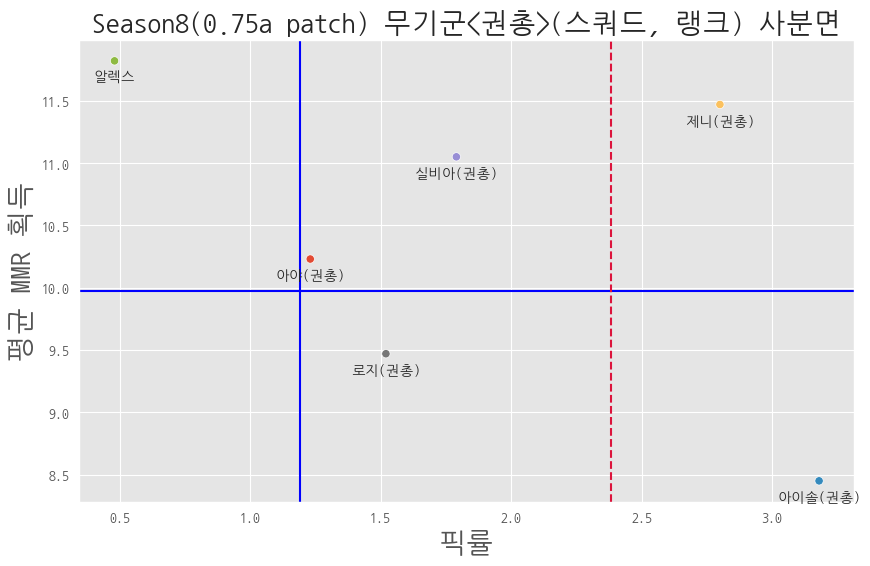

In [28]:
# 3-2-1
plt.figure(figsize=(10, 6))
plt.xlabel('픽률', fontsize=20)
plt.ylabel('평균 MMR 획득', fontsize=20)
sns.scatterplot(xyw, x=xyw.pickRate, y=xyw.mmrGain, hue=xyw.characterName, legend=False)
plt.title(f'Season8(0.75a patch) 무기군<{w}>(스쿼드, 랭크) 사분면', fontsize=20)
plt.axhline(mmr, 0, 1, color='blue')
plt.axvline(pick, 0, 1, color='blue')
plt.axvline(pick * 2, 0, 1, linestyle='--', color='crimson')
for _, j in xyw.iterrows():
    plt.annotate(j.characterName,
                 (j.pickRate, j.mmrGain),
                 textcoords="offset points",  # 텍스트 위치를 (x,y)로 부터의 오프셋 (offset_x, offset_y)로 지정
                 xytext=(0, -15),  # (x, y)로 부터의 오프셋 (offset_x, offset_y)
                 ha='center')
plt.show()

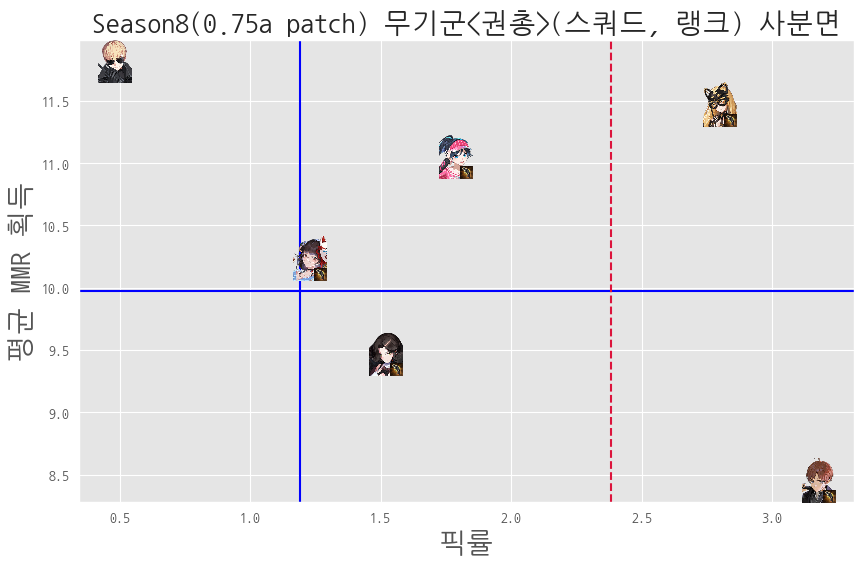

In [29]:
# 3-2-2
plt.style.use(style='ggplot')
# plt.figure(figsize=(22, 14))
plt.rcParams['figure.figsize'] = (10, 6)

fig, ax = plt.subplots()
plt.axhline(mmr, 0, 1, color='blue')
plt.axvline(pick, 0, 1, color='blue')
plt.axvline(pick * 2, 0, 1, linestyle='--', color='crimson')
for x, y, image_path, characterName in zip(wgraphData.x, wgraphData.y, wgraphData.image, wgraphData.characterName):
    if ax is None:
        ax = plt.gca()
    try:
        image = plt.imread(image_path)
    except TypeError:
        pass
    im = OffsetImage(image, zoom=0.2)
    x, y = np.atleast_1d(x, y)
    artists = []
    for x0, y0 in zip(x, y):
        ab = AnnotationBbox(im, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    # ax.annotate(characterName, (x, y), textcoords="offset points", xytext=(0, -25), ha='center') # 텍스트 출력
plt.title(f'Season8(0.75a patch) 무기군<{w}>(스쿼드, 랭크) 사분면', fontsize=20)
plt.xlabel('픽률', fontsize=20)
plt.ylabel('평균 MMR 획득', fontsize=20)

plt.show()

# fin
크롤링하여 사용한 자료는 0.75 ~ 0.75a 패치 버전의 데이터이고 현재 패치 버전은 0.77b이다.


메타 분석

     스킬 증폭 아이템: 지휘관의갑옷, 제국왕관, 틴달로스의 팔찌, 풍화륜 => 사용 아이템의 대부분이 스킬 증폭 아이템인걸 보면 평타 딜러보단 스킬딜러가 주도하는 메타임을 알 수 있다.
     뚜언띠엔: 방어력, 쿨타임 감소 무기 => 픽률 1위의 유키가 주로 쓰는 무기
     오르골: 공격 속도 아이템 => 현재 장신구 api에 버그가 있어서 신뢰할수 없음

     팀 게임인 스쿼드 모드라서 그런지 후방지원형 실험체가 준수한 통계를 보여주고 있다.
     요한: 픽률은 평균이지만 전체 3위의 mmr 획득
     프리야: 픽률은 낮은편이지만 준수한 mmr 획득
     테오도르: 픽률 2위, 픽률대비 준수한 mmr 획득



스킨 분석

     몇몇 캐릭은 스킨이 있음에도 불구하고 기본스킨이 가장 많이 쓰임(쇼우, 아델라, 윌리엄, 나타폰, 아디나, 피올로, 알렉스, 펠릭스)
     성능에 하자가 있는 캐릭: 쇼우 => 스킨의 사용유무는 실험체의 성능에 좌우됨을 알 수 있음
     비인기 캐릭: 나타폰 => 스킨의 사용유무는 실험체의 인기에 좌우됨을 알 수 있음
     스킨이 기본일러만 못한 캐릭: 윌리엄, 알렉스 => 스킨의 사용유무는 퀄리티에 좌우됨을 알 수 있음
     아디나, 아델라, 피올로, 펠릭스 => 알 수 없음

    특이사항
     보통은 최신스킨이나 등급이 높은 스킨이 가장 많이 쓰이는데 유키의 경우는 초기 스킨인 사관후보생 유키가 가장 많이 쓰임

앞으로의 패치 방향성 추측

    실험체
     유키(양손검), 테오도르(저격총) => 비정상적 픽률은 너프 대상임을 추측 가능
     마이(채찍), 시셀라(투척), 제니(권총), 카밀로(레이피어) => 평균을 한참 상회하는 지표를 보여주고 있어 너프 대상임을 추측 가능
     아이작(톤파), 현우(글러브), 아이솔(권총), 아야(저격총) => mmr 획등량은 평균 이하지만 평균 픽률의 2배 이상의 픽률은 너프 대상임을 추측 가능
     혜진(활) => 평균 이상의 준수한 지표는 너프 대상임을 추측 가능
     요한(아르카나) => 솔로모드에선 도태되었지만 다인모드에선 준수한 통계를 보여주고 있어서 너프 대상 혹은 주시 대상임을 추측 가능

     나딘(석궁), 쇼우(창), 쇼우(단검), 자히르(투척) => 최 하위권의 지표는 버프 대상임을 추측 가능
     셀린(투척) => 안좋은 지표를 보이고 있으나 고점이 높은 캐릭이라 버프시 상위권 생태계가 망가질 수 있으므로 당장 버프는 하지 않더라도 주시 대상임을 추측 가능

    무기군
     글러브,  채찍, 기타 => 사용하는 모든 실험체가 준수한 지표를 보여주고 있어 너프 대상임을 추측 가능
     권총 => 비정상적인 픽률은  너프 대상임을 추측 가능하지만 이 픽률은 제니와 아이솔이 대부분을 차지하고있어
            모든 권총캐릭이 너프대상은 아니고 비정상적 픽률을 보이고있는 위 두 실험체는 너프 대상임을 추측 가능
     저격총 => 비정상적 픽률을 보여주고 있지만 평타 딜러인 버니스는 저조한 지표를 보여주고 있어 스킬증폭 저격총(혹은 해당 실험체)이 너프 대상임을 추측 가능
     레이피어, 아르카나, 양손검 => 대부분의 실험체가 준수한 지표를 보여주고 있고 그중 지표가 안좋은편인 실험체도
                               전체 실험체중에선 평균 근처의 지표라 당장 너프하진 않더라도 주시 대상임을 추측 가능

     쌍절곤, 돌격소총 => 픽률과 mmr 획득량 모두 낮은걸 보면 버프 대상임을 추측 가능
     석궁 => 최하위의 지표를 보유한 평타계열 석궁(혹은 해당 실험체)은 버프 대상임을 추측 가능

특이사항

    본 분석은 스쿼드 지표만으로 해석하여서 실제 패치 방향과는 차이점이 다소 생길 수 있음